<a href="https://colab.research.google.com/github/Rasheena-Arimbrathodi/Computer-Vision/blob/main/gmm_with_undesirable_with_picturepsnr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from scipy.io import loadmat
from skimage.filters import sobel
from skimage.filters import gaussian
from skimage.metrics import peak_signal_noise_ratio, mean_squared_error, structural_similarity
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix

# Load MRI data
data = loadmat('Brain.mat')
T1 = data['T1']
label = data['label']

# Smoothing using Laplacian of Gaussian approximation (Difference of Gaussians)
def laplacian_of_gaussian(image, sigma):
    gauss1 = gaussian(image, sigma)
    gauss2 = gaussian(image, sigma * np.sqrt(2))
    return gauss1 - gauss2

smoothed_normalized_T1 = np.zeros_like(T1)
for i in range(T1.shape[2]):
    smoothed_normalized_T1[:, :, i] = laplacian_of_gaussian(T1[:, :, i], sigma=1.485)  # Adjust sigma value as needed

# Smoothing using Gaussian filter with sobel
smoothed_sobel_T1 = np.zeros_like(smoothed_normalized_T1)
for i in range(T1.shape[2]):
    smoothed_sobel_T1[:, :, i] = sobel(smoothed_normalized_T1[:, :, i])

# Flatten and cluster using Gaussian Mixture Models (GMM)
gmm = GaussianMixture(n_components=6, random_state=42)  # GMM with 6 components
clustered_slices = np.zeros_like(T1)
for i in range(T1.shape[2]):
    flattened_slice = smoothed_sobel_T1[:, :, i].flatten().reshape((-1, 1))
    clustered_slices[:, :, i] = gmm.fit_predict(flattened_slice).reshape(T1.shape[:2])

# Perform evaluation for Task 2
# You can compare clustered_slices with the ground truth label to assess accuracy using appropriate metrics
def evaluate_segmentation(segmented_slices, ground_truth):
    num_slices = segmented_slices.shape[2]
    all_tp = 0
    all_tn = 0
    all_fp = 0
    all_fn = 0

    for i in range(num_slices):
        segmented_slice = segmented_slices[:, :, i]
        gt_slice = ground_truth[:, :, i]

        # Compute confusion matrix
        cm = confusion_matrix(gt_slice.ravel(), segmented_slice.ravel())

        # Accumulate counts
        tn, fp, fn, tp = np.ravel(cm)[:4]  # Ensure only the first 4 elements are considered
        all_tp += tp
        all_tn += tn
        all_fp += fp
        all_fn += fn

    # Calculate macro-averaged metrics
    total_samples = all_tp + all_tn + all_fp + all_fn
    macro_accuracy = (all_tp + all_tn) / total_samples
    macro_sensitivity = all_tp / (all_tp + all_fn)
    macro_specificity = all_tn / (all_tn + all_fp)
    macro_dice = (2 * all_tp) / (2 * all_tp + all_fp + all_fn)

    return macro_accuracy, macro_sensitivity, macro_specificity, macro_dice

# Evaluate segmentation
macro_accuracy, macro_sensitivity, macro_specificity, macro_dice = evaluate_segmentation(clustered_slices, label)

print("Macro-Averaged Accuracy:", macro_accuracy)
print("Macro-Averaged Sensitivity:", macro_sensitivity)
print("Macro-Averaged Specificity:", macro_specificity)
print("Macro-Averaged Dice Coefficient:", macro_dice)

# Calculate PSNR, MSE, and SSIM
psnr_scores = []
mse_scores = []
ssim_scores = []
for i in range(T1.shape[2]):
    psnr = peak_signal_noise_ratio(label[:, :, i], clustered_slices[:, :, i], data_range=T1.max() - T1.min())
    mse = mean_squared_error(label[:, :, i], clustered_slices[:, :, i])
    ssim = structural_similarity(label[:, :, i], clustered_slices[:, :, i])
    psnr_scores.append(psnr)
    mse_scores.append(mse)
    ssim_scores.append(ssim)

print("Average PSNR:", np.mean(psnr_scores))
print("Average MSE:", np.mean(mse_scores))
print("Average SSIM:", np.mean(ssim_scores))


Macro-Averaged Accuracy: 0.9802547686621346
Macro-Averaged Sensitivity: 0.8769137045081316
Macro-Averaged Specificity: 0.9916955260819715
Macro-Averaged Dice Coefficient: 0.8985113918554001
Average PSNR: 106.894192008812
Average MSE: 4.927826081421697
Average SSIM: 0.9999926989386317


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


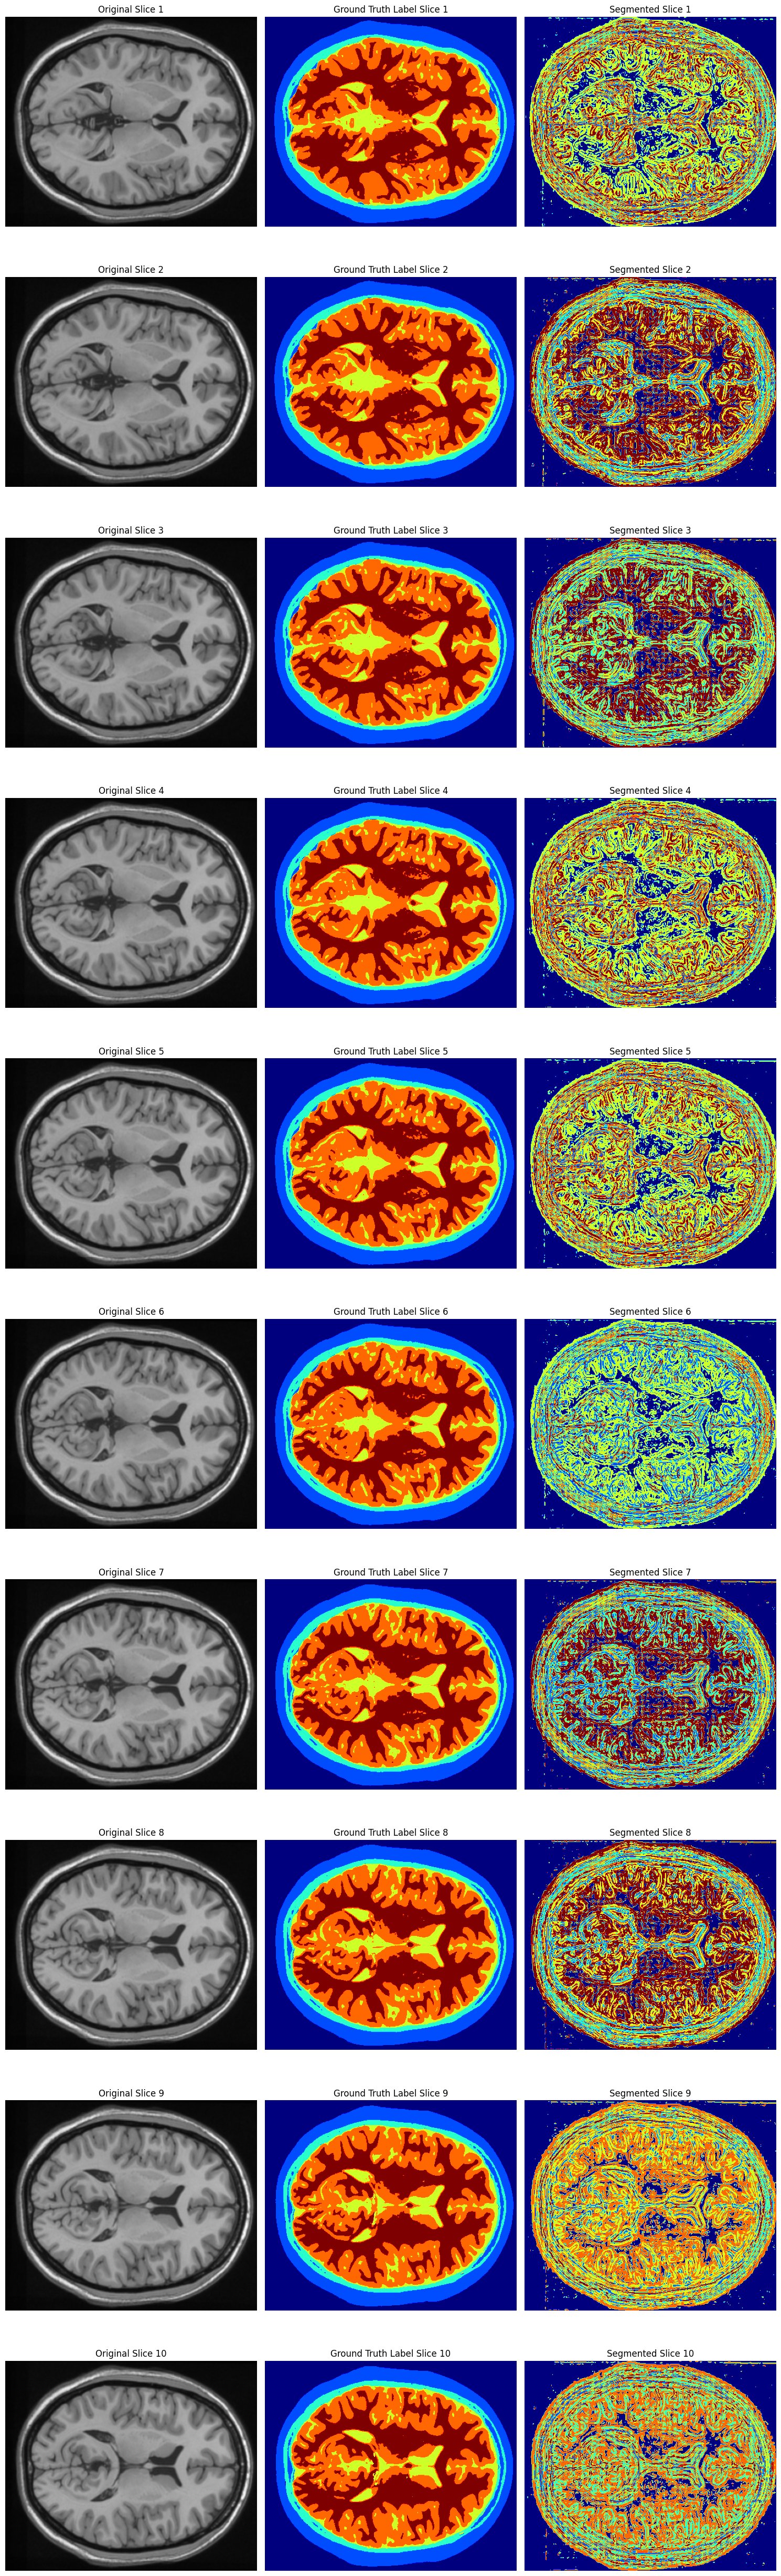

In [ ]:
import matplotlib.pyplot as plt
num_slices = T1.shape[2]
fig, axes = plt.subplots(num_slices, 3, figsize=(15, 5 * num_slices))

for i in range(num_slices):
    # Original MRI slice
    axes[i, 0].imshow(T1[:, :, i], cmap='gray')
    axes[i, 0].set_title(f"Original Slice {i+1}")
    axes[i, 0].axis('off')

    # Ground truth label slice
    axes[i, 1].imshow(label[:, :, i], cmap='jet')
    axes[i, 1].set_title(f"Ground Truth Label Slice {i+1}")
    axes[i, 1].axis('off')

    # Segmented slice
    axes[i, 2].imshow(clustered_slices[:, :, i], cmap='jet')
    axes[i, 2].set_title(f"Segmented Slice {i+1}")
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()